In [1]:
import os
import sys
import pandas as pd
import numpy as np
from os.path import join
from tqdm import tqdm
import site
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics 
site.addsitedir('../include')

from visualize import plot_action_list, get_labels
from utils import load_action_map, f_score, edit_score
counter = 0

In [9]:
#base_dir = r"C:\Users\smuel\Data\2024_SICS_Phase"
#gt_dir = join(base_dir, 'groundTruth2')
base_dir = "/home/simon/Code/MS-TCN2/data/cataract101_rgb/"
gt_dir = "/home/simon/Code/MS-TCN2/data/cataract101_rgb/groundTruth/"

ground_truth_path = os.listdir(gt_dir)[counter]
#ground_truth_path = 'BN_0086.txt'
ground_truth_path = "case_288.txt"
ground_truth_orig = open(join(gt_dir, ground_truth_path), 'r').read().split('\n')
# print(ground_truth[2120:2140])

action_dict = load_action_map(join(base_dir,'mapping.txt'))
labels = get_labels('sics73')
counter += 3

combinations = [['cautery', 'peritomy'], 
                ['scleral_groove', 'incision', 'tunnel'],
                ['hydroprocedure', 'nucleus_prolapse', 'nucleus_delivery'],
                ['stromal_hydration', 'tunnel_suture']]
print(counter)

3


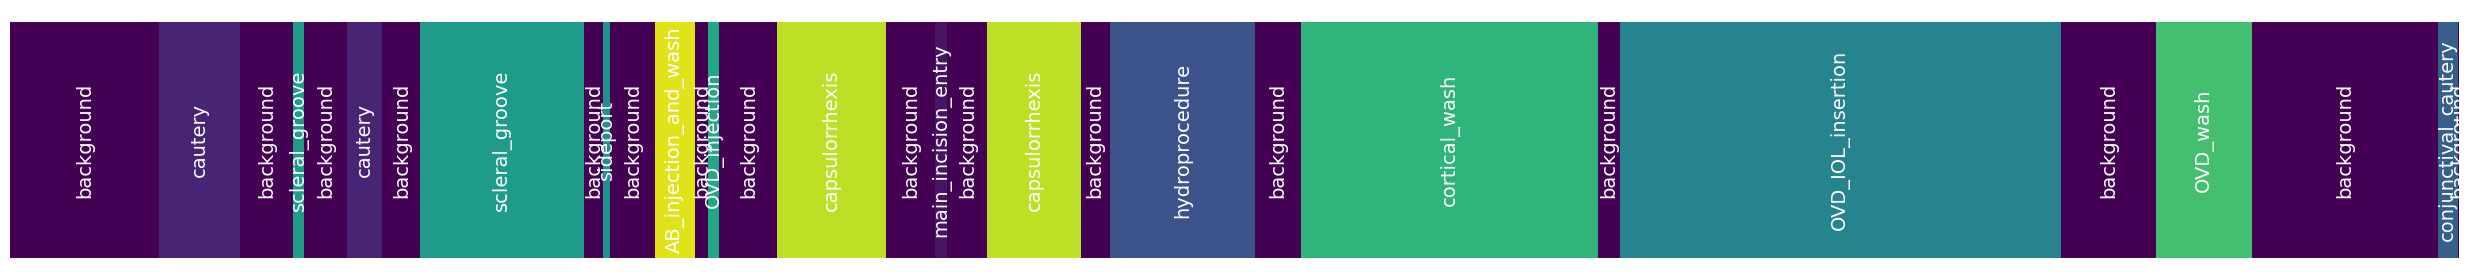

In [ ]:
ax = plot_action_list(ground_truth_orig, labels)
plt.show()

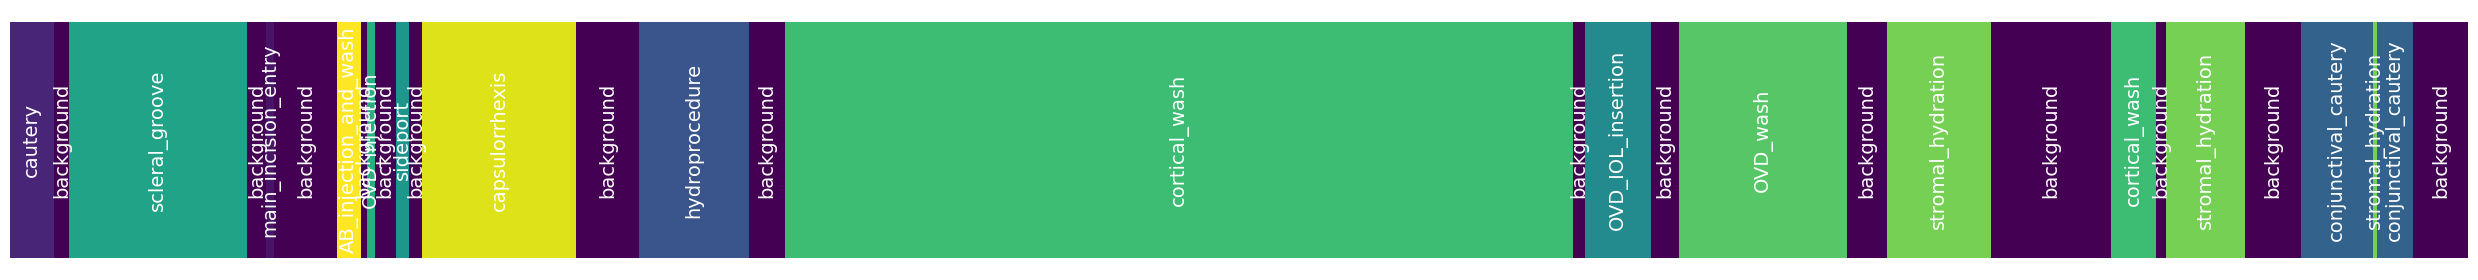

In [ ]:
def reduce_classes_in_gt(actions, combinations, bg='background'):
    flag_combine = False
    start_idx = -1
    last_class = None
    end_idx = -1
    inside_anno = False
    
    # Combine certain actions
    for comb in combinations:
        actions = [comb[0] if action in comb else action for action in actions]

    # Combine actions that are the same and are next to each other
    for idx, action in enumerate(actions):
        cur_class = actions[idx]
        
        if not inside_anno and cur_class != 'background' and cur_class != last_class:
            inside_anno = True
            start_idx = idx
            continue
        elif not inside_anno and cur_class != 'background' and last_class == cur_class:
            inside_anno = True
            flag_combine = True
            continue
        
        if inside_anno and cur_class == 'background' and not flag_combine:
            inside_anno = False
            end_idx = idx - 1
            last_class = actions[end_idx]
        elif inside_anno and cur_class == 'background' and flag_combine:
            flag_combine = False
            inside_anno = False
            end_idx = idx - 1
            last_class = actions[end_idx]
            for i in range(start_idx, end_idx+1):
                actions[i] = last_class
    return actions


ground_truth = ground_truth_orig.copy()
ground_truth = reduce_classes_in_gt(ground_truth, combinations)

ax = plot_action_list(ground_truth, labels)
plt.show()

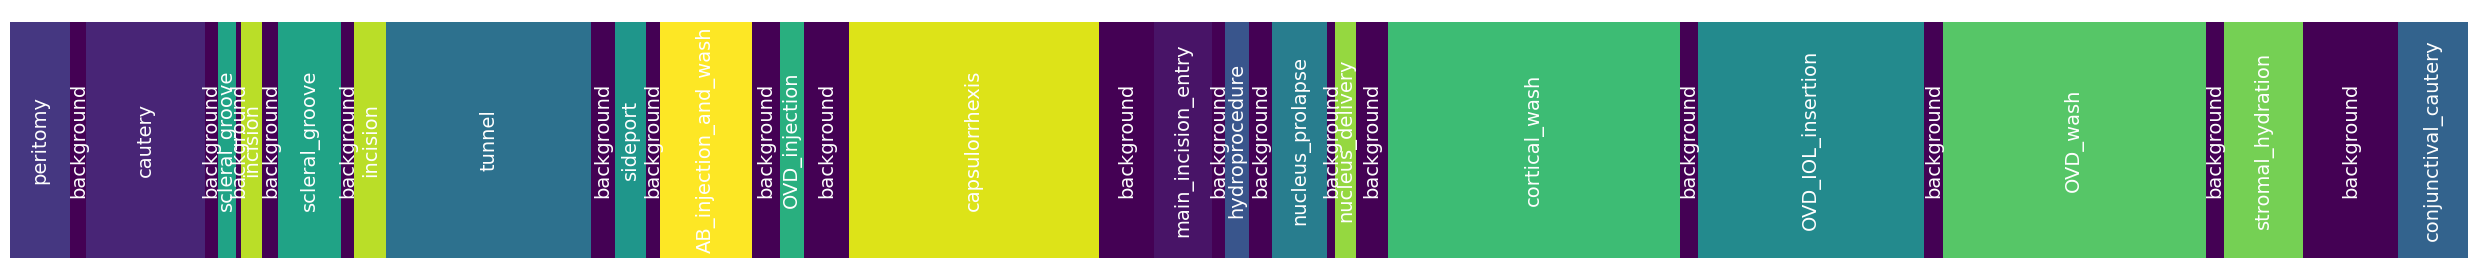

In [ ]:
ax = plot_action_list(ground_truth_orig, labels)
plt.show()

In [ ]:
def can_combine(action1, action2, combinations):
    for comb in combinations:
        if action1 in comb and action2 in comb:
            return True
    return False

True

## Experiment 2: ROC curves for results

In [5]:
def prepare_results(ground_truth_dir, results_dir, action_dict, sample_rate=1):
    results_files = os.listdir(results_dir)
    probability_files = [file for file in results_files if 'npy' in file]

    actions2num = np.vectorize(lambda d: action_dict[d])
    results = {"labels": [], "predictions": [], "probs": []}

    for probs_files in tqdm(probability_files):
        probs = np.load(join(results_dir, probs_files))[:, 0::sample_rate]
        prediction = open(join(results_dir, probs_files.replace('.npy', '')), 'r').read().split('\n')[1].split()
        ground_truth = open(join(ground_truth_dir, probs_files.replace('.npy', '.txt')), 'r').read().split('\n')
        ground_truth = ground_truth[0::sample_rate]
        ground_truth = ground_truth[:probs.shape[1]]
        prediction = prediction[0::sample_rate]
        prediction = prediction[:probs.shape[1]]
        assert probs.shape[1] == len(ground_truth)

        ground_truth = actions2num(ground_truth)
        prediction = actions2num(prediction)

        results["labels"].append(ground_truth)
        results["predictions"].append(prediction)
        results["probs"].append(probs)
    return results

results_dir = "/home/simon/Code/MS-TCN2/results/sics105_c13_nobg2/splits" # r"C:\Users\smuel\Pictures\Results WESP\sics88_c13_nobg"
gt_dir = "/home/simon/Code/MS-TCN2/data/sics105_c13_nobg2/groundTruth" # r"C:\Users\smuel\Data\2024_SICS_Phase\groundTruth88_c13_nobg"

action_dict = load_action_map('/home/simon/Code/MS-TCN2/data/sics105_c13_nobg2/mapping.txt')
rev_actions = {v: k for k, v in action_dict.items()}

results = prepare_results(gt_dir, results_dir, action_dict, sample_rate=10)
print(len(results["labels"]), len(results["predictions"]), len(results["probs"]))


100%|██████████| 76/76 [00:00<00:00, 335.01it/s]

76 76 76


In [38]:
def bootstrap_test_metric(results, metric, alpha=0.5, num_samples=300, seed=0):
    rng = np.random.RandomState(seed=seed)
    idx = np.arange(len(results['labels']))
    accumulation_metric = []
    encoder = OneHotEncoder(sparse_output=False)

    for _ in range(num_samples):
        pred_idx = rng.choice(idx, size=idx.shape[0], replace=True)
        boot_label = [label for j, label in enumerate(results['labels']) if j in pred_idx]
        boot_pred = [pred for j, pred in enumerate(results['predictions']) if j in pred_idx]
        boot_prob = [probs for j, probs in enumerate(results['probs']) if j in pred_idx]
        
        if metric == metrics.roc_auc_score or metric == metrics.precision_score:
            y_true = encoder.fit_transform(np.concatenate(boot_label).reshape(-1, 1)).T
            test_mean = metric(y_true.ravel(), np.concatenate(boot_prob, axis=1).ravel(), average='macro')
        else:
            test_mean = metric(np.concatenate(boot_label), np.concatenate(boot_pred))
        
        accumulation_metric.append(test_mean)
    
    bootstrap_mean = np.mean(accumulation_metric)
    ci_lower = np.percentile(accumulation_metric, alpha/2.0)
    ci_upper = np.percentile(accumulation_metric, 100-alpha/2.0)
    return bootstrap_mean, (ci_lower, ci_upper)


print(bootstrap_test_metric(results, metrics.accuracy_score, alpha=5.0, num_samples=100, seed=0))
#print(bootstrap_test_metric(results, lambda a, b: metrics.f1_score(a, b, average='macro'), alpha=5.0, num_samples=100, seed=0))
#print(bootstrap_test_metric(results, metrics.roc_auc_score, alpha=5.0, num_samples=200, seed=0))

(0.8144382295740911, (0.7995440108664542, 0.8291023344363591))


In [6]:
acc_probs = np.concatenate(results['probs'], axis=1)
encoder = OneHotEncoder(sparse_output=False)
labels_one_hot = encoder.fit_transform(np.concatenate(results['labels']).reshape(-1, 1)).T

100%|██████████| 13/13 [00:00<00:00, 50.52it/s]


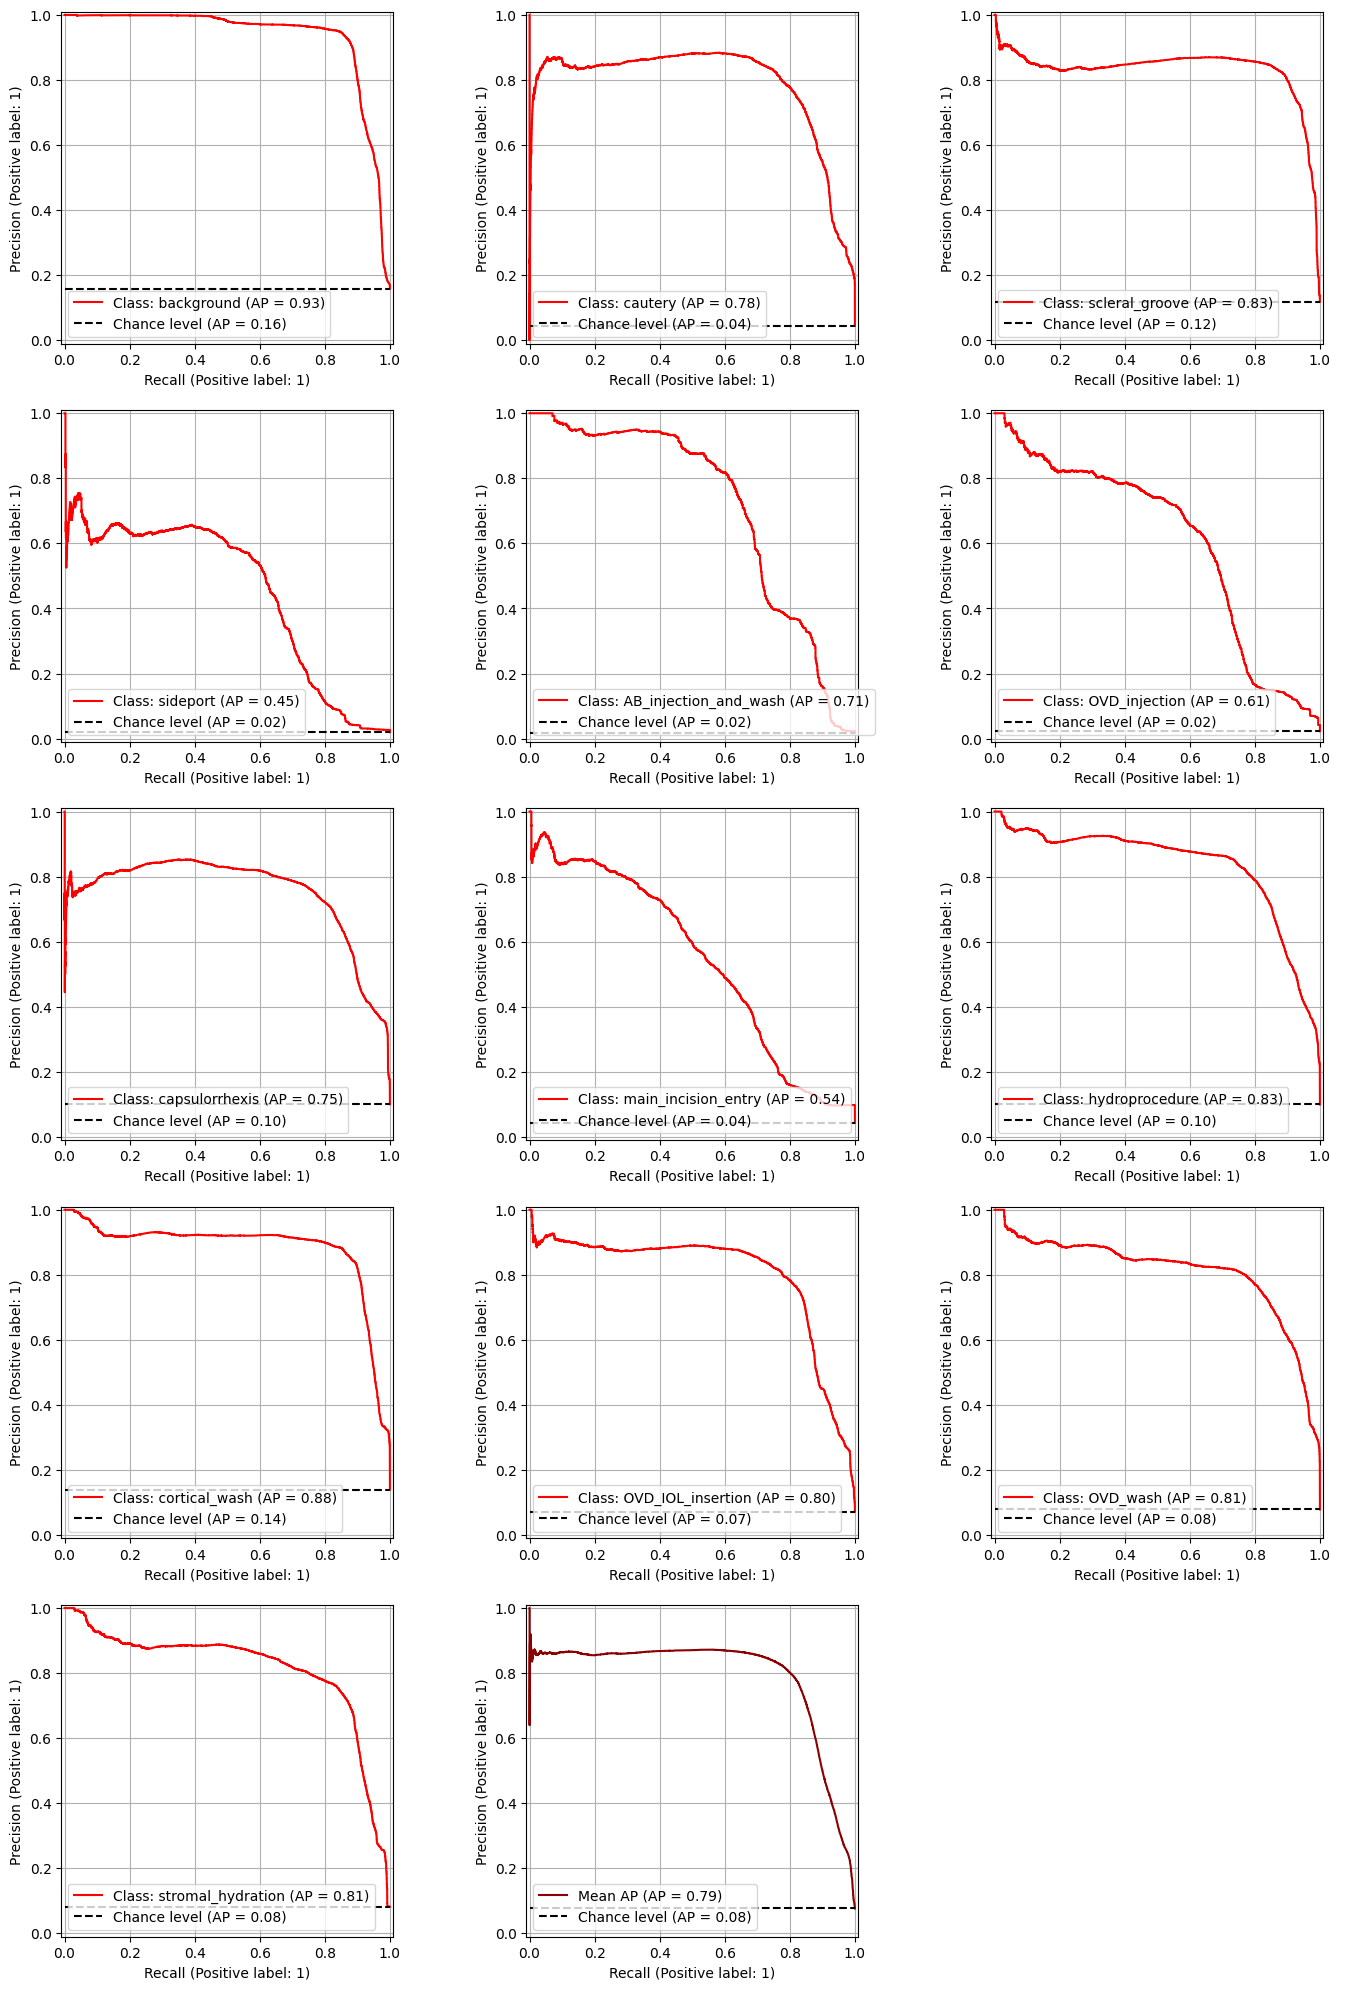

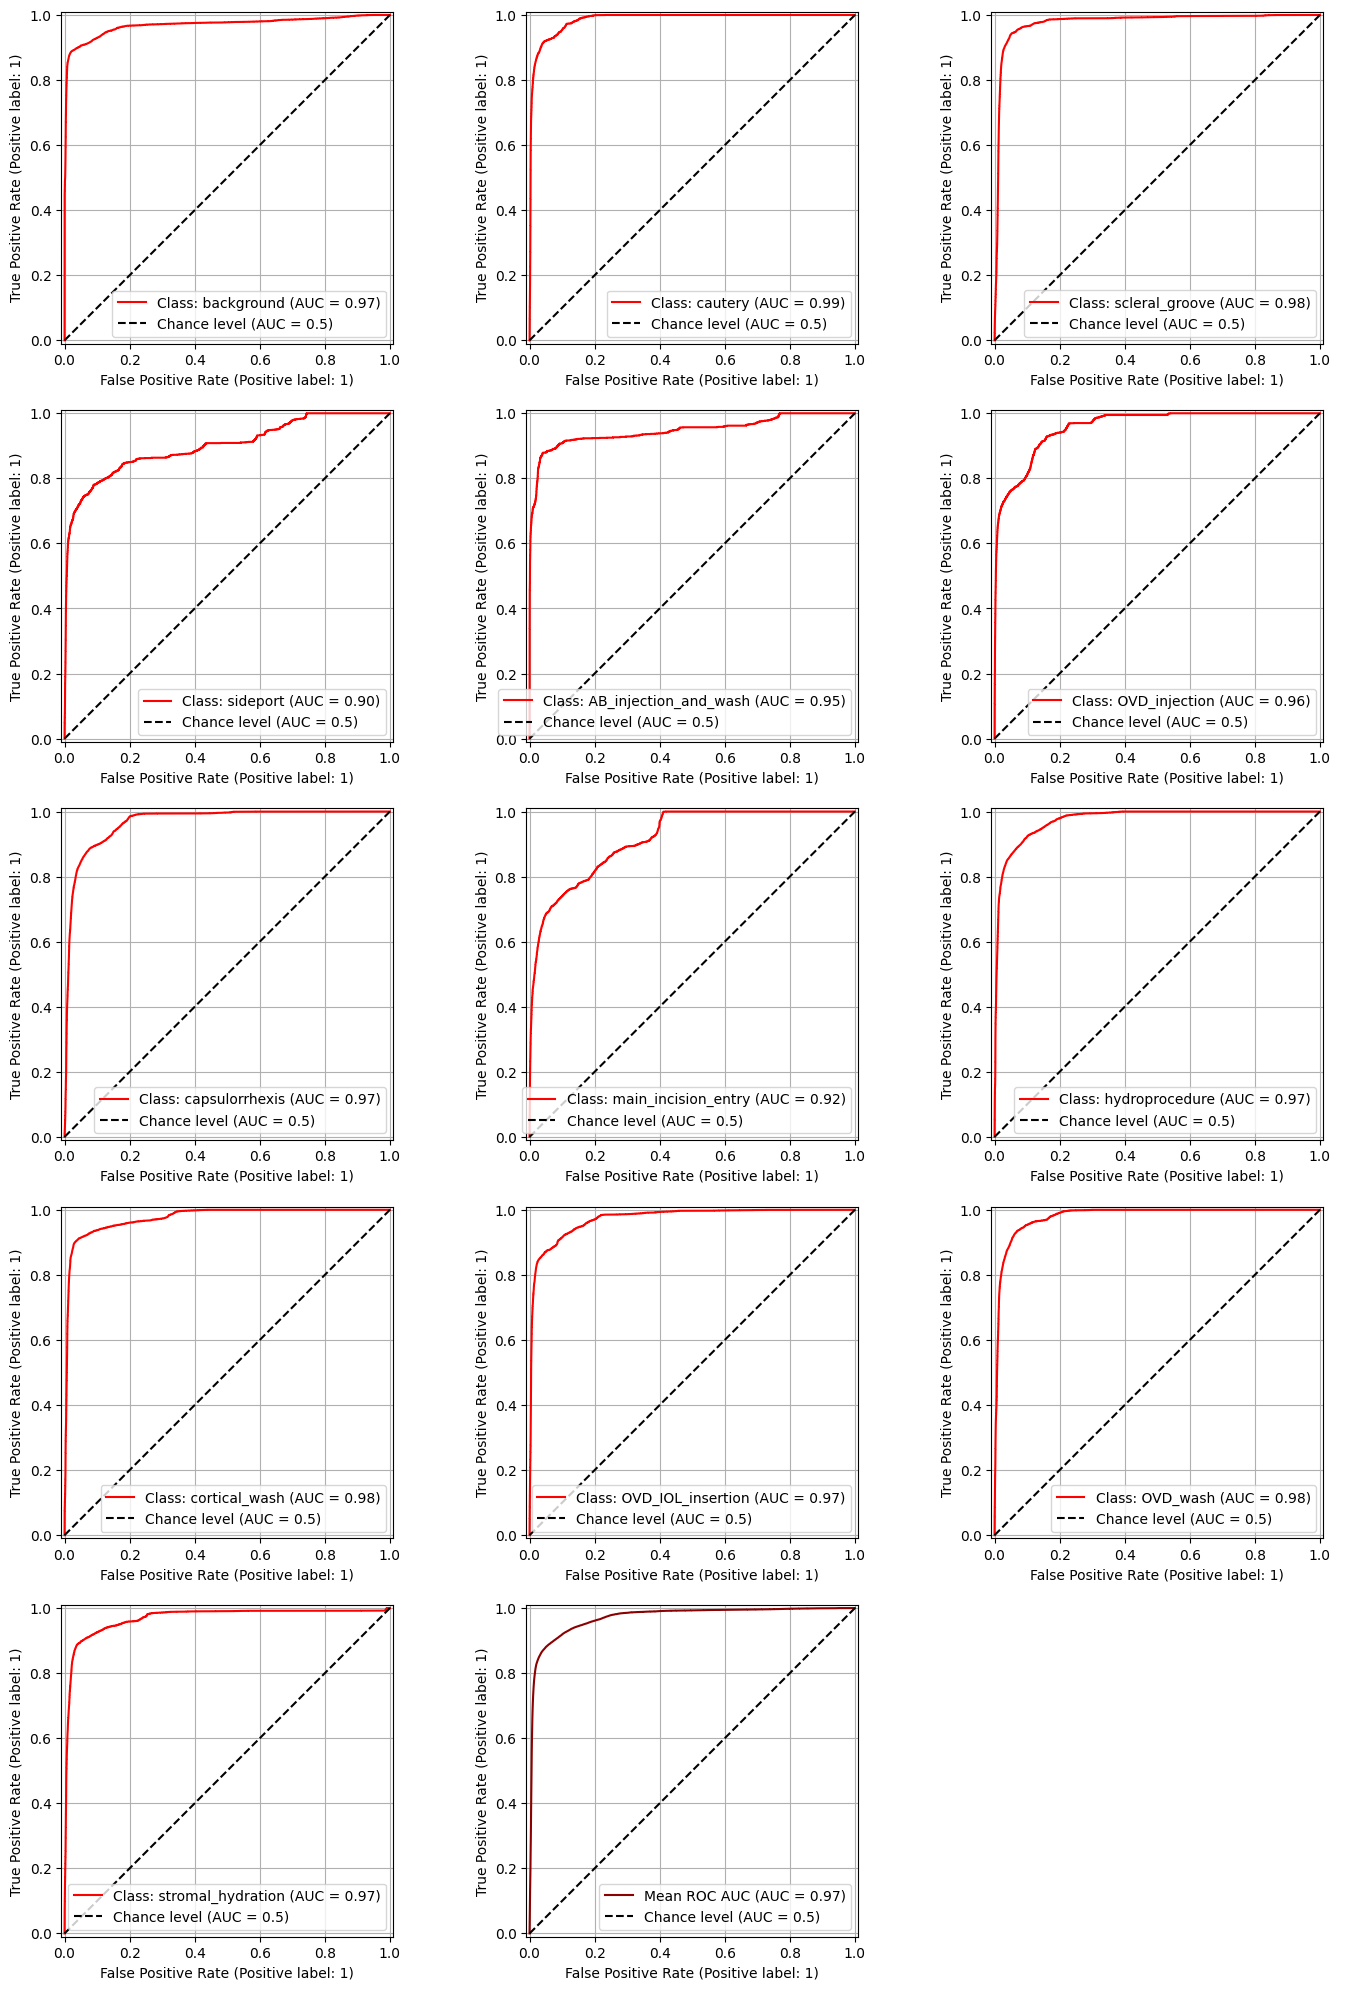

In [7]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

mode = 'sics' # 'sics'
mgraph_pos = 0 if mode == 'cataract101' else 1

fig, axs = plt.subplots(5, 3, figsize=(17, 25))
for i in tqdm(range(acc_probs.shape[0])):
    PrecisionRecallDisplay.from_predictions(labels_one_hot[i], acc_probs[i], ax=axs[i//3][i%3], plot_chance_level=True, name="Class: " + rev_actions[i], color='red')
    axs[i//3][i%3].grid()
PrecisionRecallDisplay.from_predictions(labels_one_hot.ravel(), acc_probs.ravel(), ax=axs[4][mgraph_pos], plot_chance_level=True, name="Mean AP", color='darkred')
axs[4][1].grid() 
axs[4][2].axis('off')   # Hide the subplot
if mode == 'cataract101': 
    axs[4][1].axis('off')
    axs[4][0].grid() 


fig, axs = plt.subplots(5, 3, figsize=(17, 25))
for i in tqdm(range(acc_probs.shape[0])):
    RocCurveDisplay.from_predictions(labels_one_hot[i], acc_probs[i], ax=axs[i//3][i%3], plot_chance_level=True, name="Class: " + rev_actions[i], color='red')
    axs[i//3][i%3].grid()

RocCurveDisplay.from_predictions(labels_one_hot.ravel(), acc_probs.ravel(), ax=axs[4][mgraph_pos], plot_chance_level=True, name="Mean ROC AUC", color='darkred')
axs[4][1].grid() 
axs[4][2].axis('off')   # Hide the subplot
if mode == 'cataract101': 
    axs[4][1].axis('off')
    axs[4][0].grid() 


100%|██████████| 12/12 [00:00<00:00, 44.31it/s]


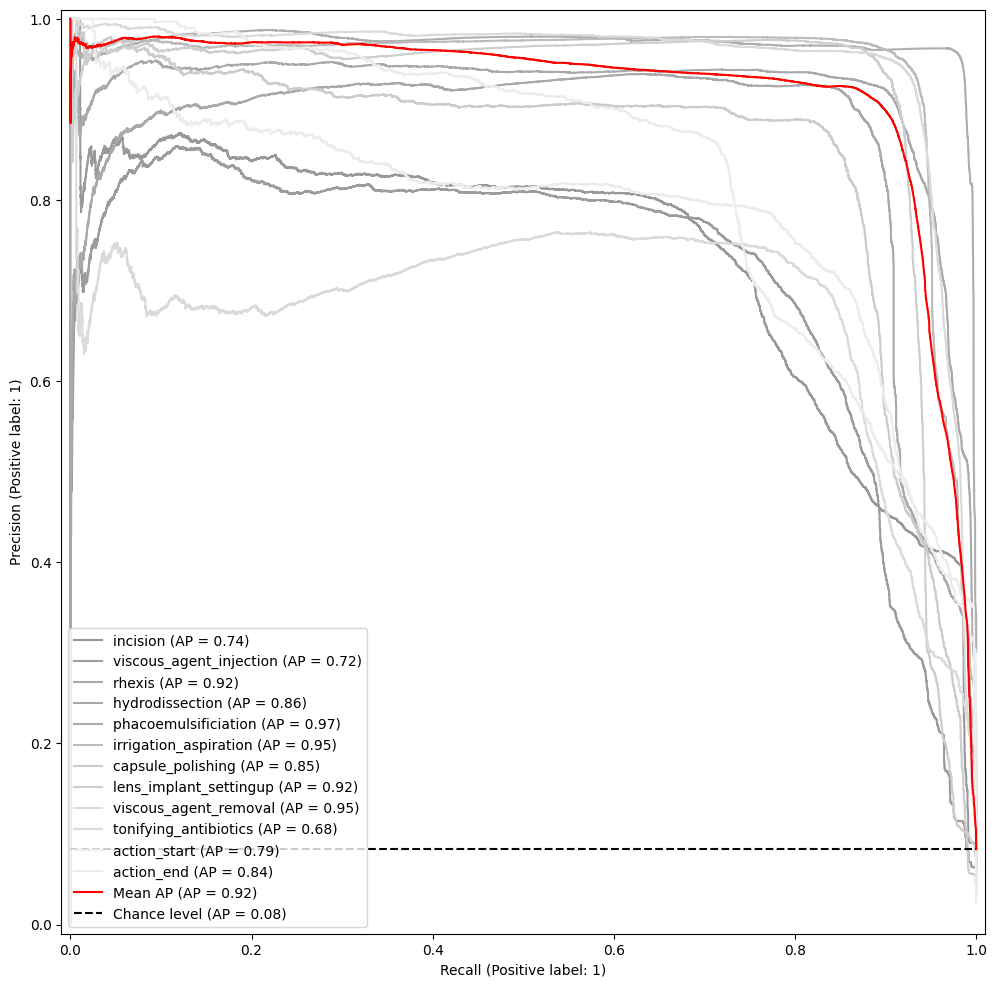

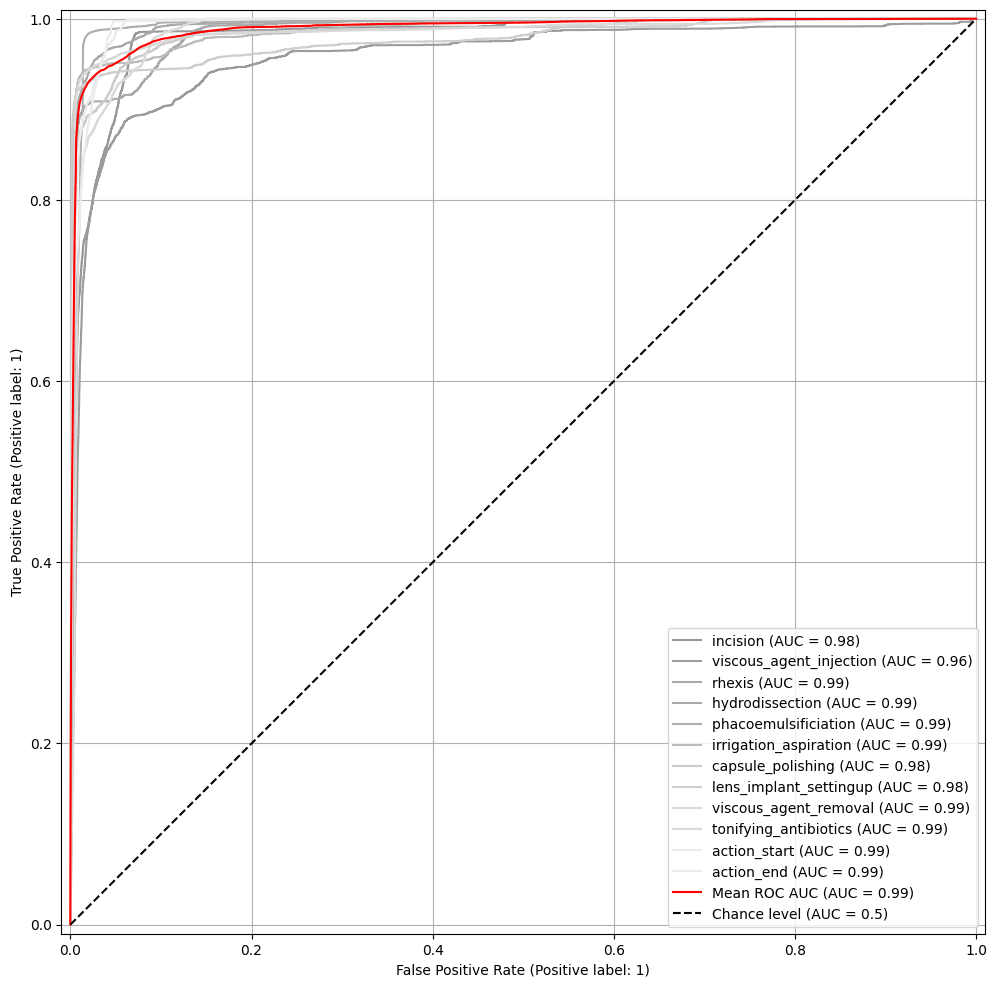

In [21]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
import random

fig, axs = plt.subplots(1, 1, figsize=(12, 12))
colors = ["#"+''.join([random.choice('9ABCDE') for j in range(2)]*3) for _ in range(acc_probs.shape[0])]
colors.sort()

for i in tqdm(range(acc_probs.shape[0])):
    
    PrecisionRecallDisplay.from_predictions(labels_one_hot[i], acc_probs[i], ax=axs, name=rev_actions[i], color=colors[i])
    axs.grid()
PrecisionRecallDisplay.from_predictions(labels_one_hot.ravel(), acc_probs.ravel(), ax=axs, plot_chance_level=True, name="Mean AP", color='red')

fig, axs = plt.subplots(1, 1, figsize=(12, 12))
for i in tqdm(range(acc_probs.shape[0])):
    RocCurveDisplay.from_predictions(labels_one_hot[i], acc_probs[i], ax=axs, name=rev_actions[i], color=colors[i])
axs.grid()
RocCurveDisplay.from_predictions(labels_one_hot.ravel(), acc_probs.ravel(), ax=axs, plot_chance_level=True, name="Mean ROC AUC", color='red')

## Caclulate mean differences between two phase annotators

In [14]:
anno1 = pd.read_excel(r"C:\Users\smuel\Code\ICC sequences\Annotation01.xlsx")
anno2 = pd.read_excel(r"C:\Users\smuel\Code\ICC sequences\Annotation02.xlsx")

columns = anno2.columns

merged_df = pd.merge(anno1, anno2, on="Video ID", suffixes=["_1", "_2"])
# merged_df.fillna(pd.to_datetime("00:00"), inplace=True)
# print(merged_df.head())

def to_seconds(value):
    try: return value.hour * 60 + value.minute
    except: return np.random.randint(0, 2)

diffs = []
for col in columns[3:]:
    values1 = merged_df[col + "_1"].apply(to_seconds).values
    values2 = merged_df[col + "_2"].apply(to_seconds).values
    mean_diff = np.mean(values1 - values2)
    diffs.append(np.abs(mean_diff))
    #print(f'Average time difference for {col}: {mean_diff}s')

print(f"Mean differences between annotations: {np.mean(diffs):.2f}s ({np.std(diffs):.4f})")



Mean differences between annotations: 0.46s (0.5361)


In [12]:
from sklearn.metrics import accuracy_score, f1_score

results_dir = "/home/simon/Code/MS-TCN2/results/sics105_c13_nobg/split_9" # r"C:\Users\smuel\Pictures\Results WESP\sics88_c13_nobg"
gt_dir = "/home/simon/Code/MS-TCN2/data/sics105_c13_nobg/groundTruth" # r"C:\Users\smuel\Data\2024_SICS_Phase\groundTruth88_c13_nobg"

action_dict = load_action_map('/home/simon/Code/MS-TCN2/data/sics105_c13_nobg/mapping.txt')
action_dict2 = load_action_map('/home/simon/Code/MS-TCN2/data/cataract101_rgb/mapping.txt')
results_sics = prepare_results(gt_dir, results_dir, action_dict, sample_rate=15)

results_dir = "/home/simon/Code/MS-TCN2/results/cataract101_rgb/split_9" # r"C:\Users\smuel\Pictures\Results WESP\sics88_c13_nobg"
gt_dir = "/home/simon/Code/MS-TCN2/data/cataract101_rgb/groundTruth" # r"C:\Users\smuel\Data\2024_SICS_Phase\groundTruth88_c13_nobg"
results_phaco = prepare_results(gt_dir, results_dir, action_dict2, sample_rate=15)


def calc_sen_spec(gt, preds, metric='sens'):
            tp, tn, fp, fn = collaps_confusion_matrix(gt, preds)
            return tp / (tp + fn) if metric == 'sens' else tn / (tn + fp)
        





100%|██████████| 14/14 [00:00<00:00, 76.11it/s]
